In [1]:
#classes = hp['classes']

import pandas as pd
#import xlrd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.impute import KNNImputer
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
pd.DataFrame.iteritems=pd.DataFrame.items
tf.compat.v1.disable_v2_behavior()
# change the strings to ints
#input= pd.DataFrame(pd.read_csv("US Insurance Claims Data.xlsx", encoding='utf-16-le', encoding_errors='ignore'))


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_excel("US_Insurance_Claims_Data.xlsx")

# Step 1: Separate datetime columns
datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
df_datetime = df[datetime_cols]

# Step 2: Exclude datetime columns for KNN imputation
df_knn = df.drop(columns=datetime_cols).copy()

# Step 3: Label encode categorical columns
label_encoders = {}
for col in df_knn.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_knn[col] = le.fit_transform(df_knn[col].astype(str))
    label_encoders[col] = le

# Step 4: Apply KNN imputer
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(imputer.fit_transform(df_knn), columns=df_knn.columns)

# Step 5: Round integer columns
for col in df_knn.select_dtypes(include='int64').columns:
    df_knn_imputed[col] = df_knn_imputed[col].round().astype(int)

# Step 6: Reverse label encoding
for col, le in label_encoders.items():
    df_knn_imputed[col] = df_knn_imputed[col].round().astype(int)
    df_knn_imputed[col] = le.inverse_transform(df_knn_imputed[col])

# Step 7: Reattach datetime columns
df_cleaned = pd.concat([df_knn_imputed, df_datetime.reset_index(drop=True)], axis=1)

# Step 8: Final check
print("Missing values after KNN imputation:", df_cleaned.isnull().sum().sum())

# Optional: Save result
df_cleaned.to_csv("US_Insurance_KNN_Imputed.csv", index=False)
input=pd.read_csv("US_Insurance_KNN_Imputed.csv")
input=input.fillna(method='bfill').fillna(method='ffill')

Missing values after KNN imputation: 0


/var/folders/ql/5nmrkn3145n9_pzr7h7w7_gh0000gn/T/ipykernel_19738/3358762314.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  input=input.fillna(method='bfill').fillna(method='ffill')


In [3]:
input.incident_location=input.incident_location.astype('category').cat.codes
input.policy_state=input.policy_state.astype('category').cat.codes
input.insured_education_level=input.insured_education_level.astype('category').cat.codes
input.insured_sex=input.insured_sex.astype('category').cat.codes
input.insured_hobbies=input.insured_hobbies.astype('category').cat.codes
input.insured_relationship=input.insured_relationship.astype('category').cat.codes
input.incident_type=input.incident_type.astype('category').cat.codes
input.collision_type=input.collision_type.astype('category').cat.codes
input.incident_severity=input.incident_severity.astype('category').cat.codes
input.authorities_contacted=input.authorities_contacted.astype('category').cat.codes
input.incident_state=input.incident_state.astype('category').cat.codes
input.incident_city=input.incident_city.astype('category').cat.codes
input.insured_occupation=input.insured_occupation.astype('category').cat.codes
input.property_damage=input.property_damage.astype('category').cat.codes
input.police_report_available=input.police_report_available.astype('category').cat.codes
input.auto_make=input.auto_make.astype('category').cat.codes
input.auto_model=input.auto_model.astype('category').cat.codes
#input['fraud_reported']=input['fraud_reported'].fillna(method='ffill').fillna(method='bfill')
input.fraud_reported=input.fraud_reported.astype('category').cat.codes
input.incident_date=input.incident_date.astype('category').cat.codes
input.policy_bind_date=input.incident_date.astype('category').cat.codes
input['policy_csl'] = input['policy_csl'].apply(lambda x: eval(x))

In [7]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.preprocessing.sequence import pad_sequences

#trainX_padded = pad_sequences(trainX, padding='post', truncating='post')
#testX_padded = pad_sequences(testX, padding='post', truncating='post')
#trainY_padded = pad_sequences(trainY, padding='post', truncating='post')
#testY_padded = pad_sequences(testY, padding='post', truncating='post')



grouped = input.groupby('months_as_customer')

# Extract sequences and labels
sequences = grouped.apply(lambda X: X[['months_as_customer', 'age', 'policy_number', 'policy_bind_date' , 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make', 'auto_model', 'auto_year']].values.tolist())
labels = grouped['fraud_reported'].first().values
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad to same length (post-padding with zeros)
X = pad_sequences(sequences.tolist(), padding='post', dtype='float32')
y = np.array(labels)
# Flatten time dimension to create 2D array for VIF calculation
# Shape: (samples * timesteps, features)
X_2d_for_vif = X.reshape(-1, X.shape[2])

def calculate_vif_3d(X_2d, thresh=5.0):
    print("Calculating VIF for each feature (collapsed over timesteps)...")
    variables = list(range(X_2d.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X_2d[:, variables], ix) for ix in range(len(variables))]
        max_vif = max(vif)
        if max_vif > thresh:
            maxloc = vif.index(max_vif)
            print(f"Dropping feature at index {variables[maxloc]} with VIF={max_vif:.2f}")
            variables.pop(maxloc)
            dropped = True
    return variables

# Calculate VIF and get list of features to keep
features_to_keep = calculate_vif_3d(X_2d_for_vif, thresh=10.0)

print(f"Selected {len(features_to_keep)} features out of {X.shape[2]} based on VIF")

# Filter original X on feature dimension (3rd dimension)
X_filtered = X[:, :, features_to_keep]

# Now flatten for SMOTE and undersampling (samples, timesteps*features_kept)
X_flat = X_filtered.reshape(X_filtered.shape[0], -1)

smote = SMOTE(sampling_strategy=0.8, random_state=42)
#rus = RandomUnderSampler(random_state=1000)

# Apply SMOTE then undersampling
X_resampled, y_resampled = smote.fit_resample(X_flat, y)
#X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

timesteps = X_filtered.shape[1]
features_kept = X_filtered.shape[2]

X_resampled = X_resampled.reshape(-1, timesteps, features_kept)

#print(f"Original shape: {X.shape}")
#print(f"Filtered shape (after VIF): {X_filtered.shape}")
#print(f"Resampled shape: {X_resampled_3d.shape}")
#print(f"Original class distribution: {np.bincount(y)}")
#print(f"Resampled class distribution: {np.bincount(y_resampled)}")

# X_resampled_3d, y_resampled are now ready for your sequential model


Calculating VIF for each feature (collapsed over timesteps)...
Dropping feature at index 3 with VIF=1576338686514.00
Dropping feature at index 31 with VIF=6543.02
Dropping feature at index 37 with VIF=226.42
Dropping feature at index 1 with VIF=107.59
Dropping feature at index 9 with VIF=38.70
Dropping feature at index 5 with VIF=27.07
Dropping feature at index 7 with VIF=22.99
Dropping feature at index 34 with VIF=18.26
Dropping feature at index 26 with VIF=13.62
Selected 29 features out of 38 based on VIF



📂 Fold 1/5

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-30 14:24:34.980988: W tensorflow/c/c_api.cc:305] Operation '{name:'training_70/Adam/dense_129/bias/v/Assign' id:51218 op device:{requested: '', assigned: ''} def:{{{node training_70/Adam/dense_129/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_70/Adam/dense_129/bias/v, training_70/Adam/dense_129/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 14:24:41.148597: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_40/mul' 

🔍 Calculating SHAP values for fold 1 of 'Convex Only'

📂 Fold 2/5

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-30 14:31:36.379636: W tensorflow/c/c_api.cc:305] Operation '{name:'training_72/Adam/decay/Assign' id:53025 op device:{requested: '', assigned: ''} def:{{{node training_72/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_72/Adam/decay, training_72/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 14:31:42.851392: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_42/mul' id:52460 op device:{requested: '', a


📂 Fold 3/5

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-30 14:39:17.305521: W tensorflow/c/c_api.cc:305] Operation '{name:'true_negatives_37/Assign' id:53665 op device:{requested: '', assigned: ''} def:{{{node true_negatives_37/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_37, true_negatives_37/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 14:39:23.744932: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_43/mul' id:53941 op device:{requested: '', assigned: ''} def:{{{node los


📂 Fold 4/5

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-30 14:46:46.085229: W tensorflow/c/c_api.cc:305] Operation '{name:'training_76/Adam/lstm_28/lstm_cell/bias/m/Assign' id:56006 op device:{requested: '', assigned: ''} def:{{{node training_76/Adam/lstm_28/lstm_cell/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_76/Adam/lstm_28/lstm_cell/bias/m, training_76/Adam/lstm_28/lstm_cell/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 14:46:52.526291: W tensorflow/c/c_api.cc:305]


📂 Fold 5/5

➡️ Stage 1 | Epochs: 100 | Loss: convex_focal_loss


2025-11-30 14:54:14.544689: W tensorflow/c/c_api.cc:305] Operation '{name:'training_78/Adam/dense_145/bias/v/Assign' id:57576 op device:{requested: '', assigned: ''} def:{{{node training_78/Adam/dense_145/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_78/Adam/dense_145/bias/v, training_78/Adam/dense_145/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 14:54:21.446102: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_45/mul' 


📊 Average metrics for schedule 'Convex Only': {'loss': 0.06885945520121677, 'accuracy': 0.5941003, 'precision': 0.6016917, 'recall': 0.16579178, 'f1': 0.24270694556662775, 'auc': 0.5871290446796513}

📂 Fold 1/5

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-30 15:01:14.524353: W tensorflow/c/c_api.cc:305] Operation '{name:'training_80/Adam/dense_153/bias/v/Assign' id:59093 op device:{requested: '', assigned: ''} def:{{{node training_80/Adam/dense_153/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_80/Adam/dense_153/bias/v, training_80/Adam/dense_153/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 15:01:21.291300: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_46/mul' 


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-30 15:02:03.289906: W tensorflow/c/c_api.cc:305] Operation '{name:'true_negatives_41/Assign' id:59282 op device:{requested: '', assigned: ''} def:{{{node true_negatives_41/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_negatives_41, true_negatives_41/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-30 15:02:10.003177: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_47/mul' id:59563 op device:{requested: '', assigned: ''} def:{{{node loss_47/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_47/mul/x, loss_47/dense_154_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after runnin


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-30 15:05:05.920285: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_127/Assign' id:60269 op device:{requested: '', assigned: ''} def:{{{node true_positives_127/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_127, true_positives_127/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-30 15:05:12.326685: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_48/mul' id:60565 op device:{requested: '', assigned: ''} def:{{{node loss_48/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_48/mul/x, loss_48/dense_154_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after ru

🔍 Calculating SHAP values for fold 1 of 'Multistage_1'

📂 Fold 2/5

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-30 15:08:39.678913: W tensorflow/c/c_api.cc:305] Operation '{name:'lstm_31/lstm_cell/bias/Assign' id:61790 op device:{requested: '', assigned: ''} def:{{{node lstm_31/lstm_cell/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](lstm_31/lstm_cell/bias, lstm_31/lstm_cell/bias/Initializer/concat)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 15:08:46.449079: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_50/mul' id:62354 op device:{requested: '', assigned


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-30 15:09:27.464368: W tensorflow/c/c_api.cc:305] Operation '{name:'total_44/Assign' id:63268 op device:{requested: '', assigned: ''} def:{{{node total_44/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_44, total_44/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-30 15:09:34.482673: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_51/mul' id:63533 op device:{requested: '', assigned: ''} def:{{{node loss_51/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_51/mul/x, loss_51/dense_159_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-30 15:12:36.800806: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_91/Assign' id:64259 op device:{requested: '', assigned: ''} def:{{{node false_positives_91/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_91, false_positives_91/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-30 15:12:43.922915: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_52/mul' id:64535 op device:{requested: '', assigned: ''} def:{{{node loss_52/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_52/mul/x, loss_52/dense_159_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after ru


📂 Fold 3/5

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-30 15:16:36.132432: W tensorflow/c/c_api.cc:305] Operation '{name:'training_92/Adam/dense_162/bias/v/Assign' id:66536 op device:{requested: '', assigned: ''} def:{{{node training_92/Adam/dense_162/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_92/Adam/dense_162/bias/v, training_92/Adam/dense_162/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 15:16:43.284751: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_53/mul' 


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-30 15:17:26.848834: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_141/Assign' id:66712 op device:{requested: '', assigned: ''} def:{{{node true_positives_141/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_141, true_positives_141/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-30 15:17:33.746193: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_54/mul' id:67018 op device:{requested: '', assigned: ''} def:{{{node loss_54/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_54/mul/x, loss_54/dense_164_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after ru


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-30 15:20:26.983355: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_144/Assign' id:67714 op device:{requested: '', assigned: ''} def:{{{node true_positives_144/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_144, true_positives_144/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-30 15:20:34.321768: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_55/mul' id:68020 op device:{requested: '', assigned: ''} def:{{{node loss_55/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_55/mul/x, loss_55/dense_164_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after ru


📂 Fold 4/5

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-30 15:24:28.001781: W tensorflow/c/c_api.cc:305] Operation '{name:'training_98/Adam/dense_167/kernel/v/Assign' id:70016 op device:{requested: '', assigned: ''} def:{{{node training_98/Adam/dense_167/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_98/Adam/dense_167/kernel/v, training_98/Adam/dense_167/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 15:24:34.913214: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-30 15:25:14.987246: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_152/Assign' id:70217 op device:{requested: '', assigned: ''} def:{{{node true_positives_152/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_152, true_positives_152/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-30 15:25:22.061318: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_57/mul' id:70503 op device:{requested: '', assigned: ''} def:{{{node loss_57/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_57/mul/x, loss_57/dense_169_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after ru


➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-30 15:28:16.370354: W tensorflow/c/c_api.cc:305] Operation '{name:'true_positives_154/Assign' id:71209 op device:{requested: '', assigned: ''} def:{{{node true_positives_154/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](true_positives_154, true_positives_154/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-30 15:28:23.706147: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_58/mul' id:71505 op device:{requested: '', assigned: ''} def:{{{node loss_58/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_58/mul/x, loss_58/dense_169_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after ru


📂 Fold 5/5

➡️ Stage 1 | Epochs: 10 | Loss: convex_focal_loss


2025-11-30 15:32:12.988491: W tensorflow/c/c_api.cc:305] Operation '{name:'training_104/Adam/dense_171/bias/m/Assign' id:73417 op device:{requested: '', assigned: ''} def:{{{node training_104/Adam/dense_171/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_104/Adam/dense_171/bias/m, training_104/Adam/dense_171/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 15:32:20.387031: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_59/m


➡️ Stage 2 | Epochs: 40 | Loss: nonconvex_focal_loss


2025-11-30 15:33:03.301411: W tensorflow/c/c_api.cc:305] Operation '{name:'count_53/Assign' id:73728 op device:{requested: '', assigned: ''} def:{{{node count_53/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_53, count_53/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-30 15:33:10.516968: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_60/mul' id:73988 op device:{requested: '', assigned: ''} def:{{{node loss_60/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_60/mul/x, loss_60/dense_174_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



➡️ Stage 3 | Epochs: 50 | Loss: hybrid_nonconvex_focal_loss


2025-11-30 15:36:05.251221: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_109/Assign' id:74714 op device:{requested: '', assigned: ''} def:{{{node false_positives_109/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_109, false_positives_109/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-11-30 15:36:13.360630: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_61/mul' id:74990 op device:{requested: '', assigned: ''} def:{{{node loss_61/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_61/mul/x, loss_61/dense_174_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes afte


📊 Average metrics for schedule 'Multistage_1': {'loss': 0.021508645264790127, 'accuracy': 0.6264257, 'precision': 0.67474043, 'recall': 0.33947974, 'f1': 0.4389223725298169, 'auc': 0.6667936381619786}

📂 Fold 1/5

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-30 15:40:14.404029: W tensorflow/c/c_api.cc:305] Operation '{name:'training_110/Adam/dense_178/kernel/v/Assign' id:77041 op device:{requested: '', assigned: ''} def:{{{node training_110/Adam/dense_178/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_110/Adam/dense_178/kernel/v, training_110/Adam/dense_178/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 15:40:21.872352: W tensorflow/c/c_api.cc:305] Operation '{name:'l

🔍 Calculating SHAP values for fold 1 of 'Nonconvex Only'

📂 Fold 2/5

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-30 15:47:46.630157: W tensorflow/c/c_api.cc:305] Operation '{name:'training_112/Adam/iter/Assign' id:78894 op device:{requested: '', assigned: ''} def:{{{node training_112/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_112/Adam/iter, training_112/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 15:47:54.297609: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_64/mul' id:78306 op device:{requested: '', assigned:


📂 Fold 3/5

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-30 15:55:50.533460: W tensorflow/c/c_api.cc:305] Operation '{name:'false_positives_115/Assign' id:79554 op device:{requested: '', assigned: ''} def:{{{node false_positives_115/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_positives_115, false_positives_115/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 15:55:58.211713: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_65/mul' id:79830 op device:{requested: '', assigned: ''} def:{{{


📂 Fold 4/5

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-30 16:03:30.862987: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_192/bias/Assign' id:80996 op device:{requested: '', assigned: ''} def:{{{node dense_192/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_192/bias, dense_192/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 16:03:38.691134: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_66/mul' id:81354 op device:{requested: '', assigned: ''} def:{{{node loss_66/mul}} =


📂 Fold 5/5

➡️ Stage 1 | Epochs: 100 | Loss: nonconvex_focal_loss


2025-11-30 16:11:21.001962: W tensorflow/c/c_api.cc:305] Operation '{name:'training_118/Adam/dense_197/kernel/v/Assign' id:83608 op device:{requested: '', assigned: ''} def:{{{node training_118/Adam/dense_197/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_118/Adam/dense_197/kernel/v, training_118/Adam/dense_197/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 16:11:29.024000: W tensorflow/c/c_api.cc:305] Operation '{name:'l


📊 Average metrics for schedule 'Nonconvex Only': {'loss': 0.017663717293343345, 'accuracy': 0.5687482, 'precision': 0.52666664, 'recall': 0.034536857, 'f1': 0.06408145844765564, 'auc': 0.563054395497684}

📂 Fold 1/5

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-30 16:18:54.197025: W tensorflow/c/c_api.cc:305] Operation '{name:'false_negatives_121/Assign' id:84131 op device:{requested: '', assigned: ''} def:{{{node false_negatives_121/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](false_negatives_121, false_negatives_121/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 16:19:01.885314: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_68/mul' id:84402 op device:{requested: '', assigned: ''} def:{{{

🔍 Calculating SHAP values for fold 1 of 'Hybrid'

📂 Fold 2/5

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-30 16:26:32.678837: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_205/kernel/Assign' id:86004 op device:{requested: '', assigned: ''} def:{{{node dense_205/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_205/kernel, dense_205/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 16:26:40.654319: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_70/mul' id:86409 op device:{requested: '', assigned: ''} def:{{{nod


📂 Fold 3/5

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-30 16:34:23.681798: W tensorflow/c/c_api.cc:305] Operation '{name:'training_124/Adam/dense_212/bias/m/Assign' id:88591 op device:{requested: '', assigned: ''} def:{{{node training_124/Adam/dense_212/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_124/Adam/dense_212/bias/m, training_124/Adam/dense_212/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 16:34:31.876105: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_71/m


📂 Fold 4/5

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-30 16:42:27.075170: W tensorflow/c/c_api.cc:305] Operation '{name:'training_126/Adam/dense_219/kernel/m/Assign' id:90132 op device:{requested: '', assigned: ''} def:{{{node training_126/Adam/dense_219/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_126/Adam/dense_219/kernel/m, training_126/Adam/dense_219/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 16:42:35.109878: W tensorflow/c/c_api.cc:305] Operation '{name:'l


📂 Fold 5/5

➡️ Stage 1 | Epochs: 100 | Loss: hybrid_nonconvex_focal_loss


2025-11-30 17:14:43.194439: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_224/bias/Assign' id:90665 op device:{requested: '', assigned: ''} def:{{{node dense_224/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_224/bias, dense_224/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-11-30 17:15:18.920993: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_73/mul' id:90981 op device:{requested: '', assigned: ''} def:{{{node loss_73/mul}} =


📊 Average metrics for schedule 'Hybrid': {'loss': 0.02165488088062264, 'accuracy': 0.56453264, 'precision': 0.314359, 'recall': 0.24431352, 'f1': 0.2721194357941015, 'auc': 0.5744615729214149}
✅ Metrics exported to 'cross_validation_results_2.csv'


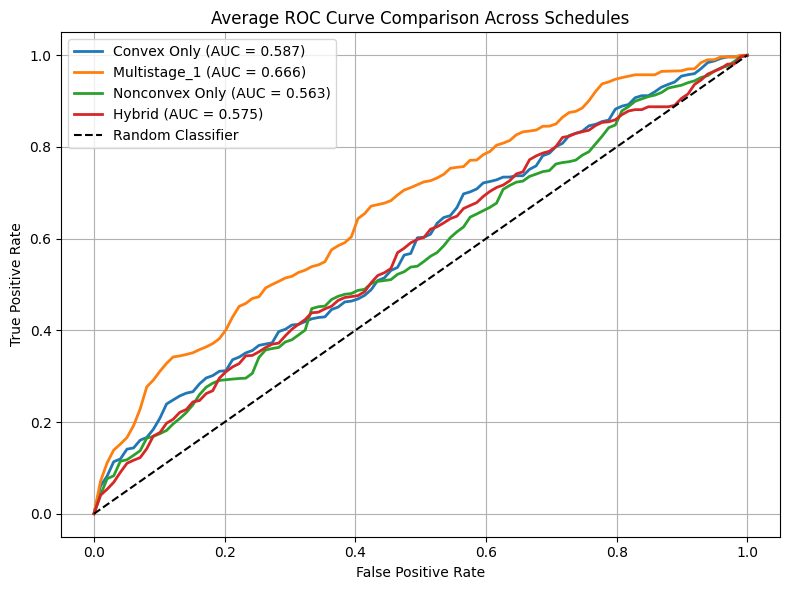

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from tensorflow.keras.metrics import Precision, Recall, AUC
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shap
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
shap_feature_importance = {}


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from sklearn.utils import class_weight




import tensorflow as tf
import tensorflow.keras.backend as K

class NoisyLossWrapper(tf.keras.losses.Loss):
    def __init__(self, base_loss_fn, noise_scale=0.5, name='noisy_loss'):
        super(NoisyLossWrapper, self).__init__(name=name)
        self.base_loss_fn = base_loss_fn
        self.noise_scale = noise_scale

    def call(self, y_true, y_pred):
        base_loss = self.base_loss_fn(y_true, y_pred)
        noise = tf.random.normal(shape=tf.shape(base_loss), mean=0.3, stddev=self.noise_scale) # make noise 0
        return base_loss + noise



def model_builder_convex():
    model = tf.keras.Sequential([
        
        # Handle padded sequences
        tf.keras.layers.Masking(
            mask_value=0.0,
            input_shape=(X_filtered.shape[1], X_filtered.shape[2])
        ),

        # Convex-compatible LSTM (tanh + sigmoid only)
        tf.keras.layers.LSTM(
            32,
            activation='tanh',              # smooth, convex-friendly
            recurrent_activation='sigmoid', # safe gating
            return_sequences=False
        ),

        # Convex dense layers
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='softplus'),
                # Extra non-convex expressiveness
        tf.keras.layers.Dense(32, activation='softplus'),

        # Output (sigmoid for BCE)
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model





def model_builder_nonconvex():
    model = tf.keras.Sequential([
        # Handles padded sequences safely
        tf.keras.layers.Masking(
            mask_value=0.0,
            input_shape=(X_filtered.shape[1], X_filtered.shape[2])
        ),

        # Non-convex temporal extractor
        tf.keras.layers.LSTM(
            32,
            activation='tanh',
            recurrent_activation='sigmoid',
            return_sequences=False,
           # kernel_initializer='glorot_uniform'
        ),

        # Deep non-convex block
        tf.keras.layers.Dense(128, activation='sigmoid'),
        tf.keras.layers.Dense(64, activation='sigmoid'),
        tf.keras.layers.Dense(32, activation='sigmoid'),

        # Extra non-convex expressiveness
        tf.keras.layers.Dense(32, activation='sigmoid'),

        # Output
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model







import tensorflow as tf

class ConvexFocalLoss(tf.keras.losses.Loss):
    """
    Convex-style Focal Loss using convex logistic link (softplus)
    instead of sigmoid. The focal term (1 - p_t)^gamma remains
    dynamic and fully inside the computational graph.
    """
    def __init__(self, gamma=0.5, alpha=0.25,
                 reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE,
                 name='convex_focal_loss'):
        super().__init__(reduction=reduction, name=name)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred_logits):

        # Softplus-based convex logistic components
        pos_term = tf.nn.softplus(-y_pred_logits)  # convex
        neg_term = tf.nn.softplus(y_pred_logits)   # convex

        # Convex surrogate "probability"
        # p = exp(-softplus(-z)) is convex in logits
        p = tf.exp(-pos_term)

        # Class-dependent p_t
        p_t = y_true * p + (1 - y_true) * (1 - p)

        # ---- Convex surrogate for focal weighting ----
        # Original: (1 - p_t)^gamma      → nonconvex
        # New convex surrogate: exp(-gamma * p_t)
        focal_weight = tf.exp(-self.gamma * p_t)   # convex & monotone decreasing

        # Base convex logistic loss
        base_loss = y_true * pos_term + (1 - y_true) * neg_term

        # Weighted convex loss (convex * convex → convex)
        loss = self.alpha * focal_weight * base_loss

        return tf.reduce_mean(loss)




convex_focal_loss_fn = ConvexFocalLoss(gamma=0.0, alpha=0.1)


#convex_focal_loss = NoisyLossWrapper(convex_focal_loss_fn, noise_scale=0.5)
convex_focal_loss=convex_focal_loss_fn
convex_focal_loss.__name__ = "convex_focal_loss"

nonconvex_focal_loss_fn = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=True, alpha=0.25, gamma=4.0, from_logits=False,
    label_smoothing=0.0, axis=-1, reduction='sum_over_batch_size'
)
#nonconvex_focal_loss = NoisyLossWrapper(nonconvex_focal_loss_fn, noise_scale=0.5)
nonconvex_focal_loss = nonconvex_focal_loss_fn
nonconvex_focal_loss.__name__ = "nonconvex_focal_loss"


hybrid_nonconvex_focal_loss_fn = tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=True, alpha=0.5, gamma=4.0, from_logits=False,
    label_smoothing=0.0, axis=-1, reduction='sum_over_batch_size'
)
#hybrid_nonconvex_focal_loss = NoisyLossWrapper(hybrid_nonconvex_focal_loss_fn, noise_scale=0.5)
hybrid_nonconvex_focal_loss = hybrid_nonconvex_focal_loss_fn
hybrid_nonconvex_focal_loss.__name__ = "hybrid_nonconvex_focal_loss"



training_schedule_convex = [
    {"loss_fn": convex_focal_loss, "epochs": 100},
]

training_schedule_multistage_1 = [
    {"loss_fn": convex_focal_loss, "epochs": 10},
     {"loss_fn": nonconvex_focal_loss, "epochs":40},
      {"loss_fn": hybrid_nonconvex_focal_loss, "epochs":50},
]

training_schedule_multistage_2 = [
    {"loss_fn": convex_focal_loss, "epochs":10},
    {"loss_fn": nonconvex_focal_loss, "epochs":90},
]


hybrid_training_schedule_nonconvex = [
    {"loss_fn": hybrid_nonconvex_focal_loss, "epochs": 100},
]

training_schedule_nonconvex = [
    {"loss_fn": nonconvex_focal_loss, "epochs": 100},
]


def cross_validate(schedule, schedule_name, X_data, y_data, k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    metrics_list = []
    roc_data = []

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data)):
        print(f"\n📂 Fold {fold + 1}/{k_folds}")

        X_train_fold, X_val_fold = X_data[train_index], X_data[val_index]
        y_train_fold, y_val_fold = y_data[train_index], y_data[val_index]

        result = train_with_schedule_fold(schedule, schedule_name, X_train_fold, y_train_fold, X_val_fold, y_val_fold, fold)
        metrics_list.append(result)
        roc_data.append((result["fpr"], result["tpr"]))

    avg_metrics = {
        "loss": np.mean([m["loss"] for m in metrics_list]),
        "accuracy": np.mean([m["accuracy"] for m in metrics_list]),
        "precision": np.mean([m["precision"] for m in metrics_list]),
        "recall": np.mean([m["recall"] for m in metrics_list]),
        "f1": np.mean([m["f1"] for m in metrics_list]),
        "auc": np.mean([m["auc"] for m in metrics_list]),
    }

    print(f"\n📊 Average metrics for schedule '{schedule_name}': {avg_metrics}")
    return avg_metrics, roc_data


def get_model_type_from_loss(loss_fn):
    name = loss_fn.__name__.lower()

    if name.startswith("convex"):
        return "convex"
    elif name.startswith("nonconvex"):
        return "nonconvex"
    elif name.startswith("hybrid"):
        return "nonconvex"   # hybrid is nonconvex
    else:
        raise ValueError(f"Unknown loss type: {loss_fn.__name__}")




def train_with_schedule_fold(schedule, schedule_name, trainX, trainY, testX, testY, fold_index):
    first_loss = schedule[0]["loss_fn"]
    model_type = get_model_type_from_loss(first_loss)

    if model_type == "convex":
        model = model_builder_convex()
        #print(f"[FOLD {fold_index}] Using CONVEX model for loss: {first_loss.__name__}")

    else:
        model = model_builder_nonconvex()
        #print(f"[FOLD {fold_index}] Using NON-CONVEX model for loss: {first_loss.__name__}")

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True
    )
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
    current_epoch = 0

    for i, stage in enumerate(schedule):
        loss_fn = stage["loss_fn"]
        epochs = stage["epochs"]
        print(f"\n➡️ Stage {i + 1} | Epochs: {epochs} | Loss: {loss_fn.__name__}")

        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
        )

        model.fit(
            trainX, trainY,
            initial_epoch=current_epoch,
            epochs=current_epoch + epochs,
            batch_size=1,
            validation_data=(testX, testY),
            verbose=0
        )
        current_epoch += epochs

    eval_results = model.evaluate(testX, testY, verbose=0)
    y_pred_prob = model.predict(testX, verbose=0).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    f1 = f1_score(testY, y_pred)
    auc_score = roc_auc_score(testY, y_pred_prob)
    fpr, tpr, _ = roc_curve(testY, y_pred_prob)

    # SHAP values for fold 1 only
    if fold_index == 0:
        print(f"🔍 Calculating SHAP values for fold 1 of '{schedule_name}'")
        background = trainX[:100].astype(np.float32)
        test_sample = testX[:100].astype(np.float32)

        # Recompile without metrics for SHAP
        model.compile(optimizer=optimizer, loss=loss_fn)

        explainer = shap.GradientExplainer(model, background)
        shap_values = explainer.shap_values(test_sample)[0]

        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        feature_names = getattr(testX, "columns", [f"Feature {i}" for i in range(testX.shape[1])])
        shap_feature_importance[schedule_name] = dict(zip(feature_names, mean_abs_shap))

    return {
        "loss": eval_results[0],
        "accuracy": eval_results[1],
        "precision": eval_results[2],
        "recall": eval_results[3],
        "auc": auc_score,
        "f1": f1,
        "fpr": fpr,
        "tpr": tpr
    }

def average_roc_curves(roc_data, num_points=100):
    mean_fpr = np.linspace(0, 1, num_points)
    tprs = []

    for fpr, tpr in roc_data:
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    return mean_fpr, mean_tpr, mean_auc

# 🧪 Run experiments and collect metrics
results_cv = {}
roc_data_schedules = {}


results_cv["Convex Only"], roc_data_schedules["Convex Only"] = cross_validate(training_schedule_convex, "Convex Only", X_resampled, y_resampled)
results_cv["Multistage_1"], roc_data_schedules["Multistage_1"] = cross_validate(training_schedule_multistage_1, "Multistage_1", X_resampled, y_resampled)
results_cv["Nonconvex Only"], roc_data_schedules["Nonconvex Only"] = cross_validate(training_schedule_nonconvex, "Nonconvex Only", X_resampled, y_resampled)
results_cv["Hybrid"], roc_data_schedules["Hybrid"] = cross_validate(hybrid_training_schedule_nonconvex, "Hybrid", X_resampled, y_resampled)
#results_cv["Multistage_2"], roc_data_schedules["Multistage_2"] = cross_validate(training_schedule_multistage_2, "Multistage_2", X_resampled, y_resampled)


# 📤 Export metrics to CSV
results_df = pd.DataFrame.from_dict(results_cv, orient='index')
results_df.to_csv("cross_validation_results_2.csv", index_label="Schedule")
print("✅ Metrics exported to 'cross_validation_results_2.csv'")

# 📊 Plot average ROC curves
plt.figure(figsize=(8, 6))
for name, data in roc_data_schedules.items():
    fpr, tpr, auc_val = average_roc_curves(data)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc_val:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("Average ROC Curve Comparison Across Schedules")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# 📊 SHAP Comparison Bar Plot
shap_df = pd.DataFrame(shap_feature_importance).fillna(0)
#shap_df["mean"] = shap_df.mean(axis=1)
shap_df
shap_df.to_csv("cross_validation_shap_2.csv", index_label="Schedule")

#shap_df = shap_df.sort_values("mean", ascending=True)
#shap_df.drop("mean", axis=1, inplace=True)


In [9]:
import numpy as np
import pandas as pd

# Suppose shap_feature_importance is a dict of lists or arrays
shap_df = pd.DataFrame(shap_feature_importance).fillna(0)

# Flatten array entries
shap_df = shap_df.applymap(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)

# Now compute row-wise mean
shap_df["mean"] = shap_df.mean(axis=1, numeric_only=True)

# Save
shap_df.to_csv("cross_validation_shap_2.csv", index_label="Schedule")
shap_df.head()



/var/folders/ql/5nmrkn3145n9_pzr7h7w7_gh0000gn/T/ipykernel_19738/4213904531.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shap_df = shap_df.applymap(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)


,Convex Only,Multistage_1,Nonconvex Only,Hybrid,mean
Feature 0,7.173557e-09,5.805338e-09,2.240209e-06,1.549992e-05,4.438276e-06
Feature 1,1.101544e-05,8.417328e-05,1.966575e-03,1.057399e-02,3.158938e-03
Feature 2,5.485641e-11,4.290887e-11,3.250900e-08,1.068273e-07,3.485850e-08
Feature 3,5.907263e-08,1.054922e-07,1.552758e-05,1.643980e-04,4.502254e-05
Feature 4,3.703423e-04,1.556508e-04,1.651363e-04,6.145025e-06,1.743186e-04


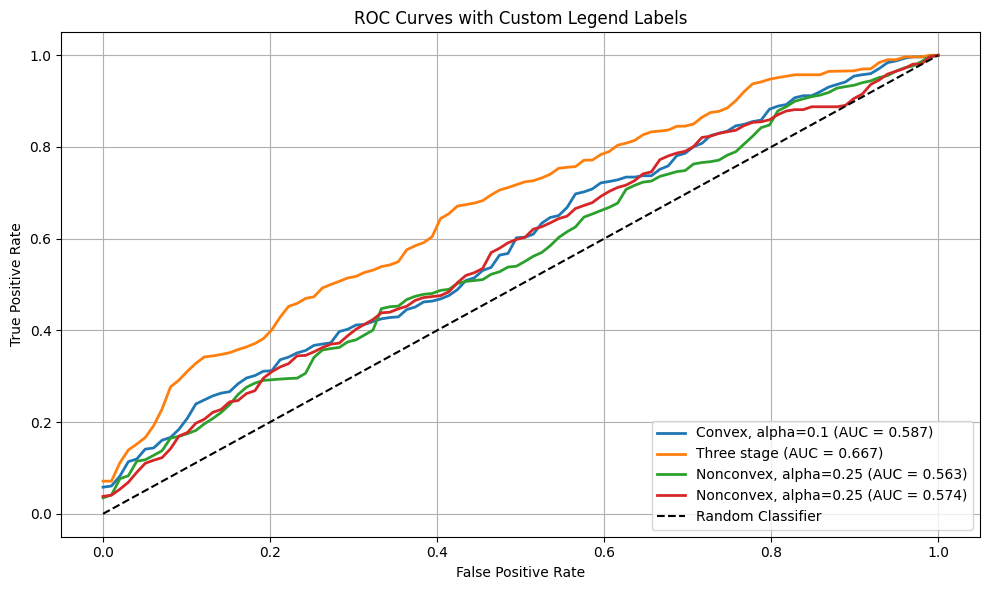

✅ Saved:
 - roc_custom_legend.png (ROC plot)
 - roc_summary_results.csv (AUC summary)
 - roc_curve_points.csv (All FPR–TPR points)


,Schedule,Label,AUC
0,Convex Only,"Convex, alpha=0.1",0.587129
1,Multistage_1,Three stage,0.666794
2,Nonconvex Only,"Nonconvex, alpha=0.25",0.563054
3,Hybrid,"Nonconvex, alpha=0.25",0.574462


,Schedule,FPR,TPR
0,Convex Only,0.000000,0.058057
1,Convex Only,0.010101,0.060673
2,Convex Only,0.020202,0.082273
3,Convex Only,0.030303,0.113709
4,Convex Only,0.040404,0.119449


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# === Function to compute average ROC curve ===
def average_roc_curves(roc_data_list):
    """
    roc_data_list: list of tuples [(fpr, tpr)] or [(fpr, tpr, auc_val)]
    Returns averaged fpr, tpr, and mean AUC
    """
    fpr_grid = np.linspace(0, 1, 100)
    tpr_interp = []
    auc_vals = []

    for entry in roc_data_list:
        # Handle 2-tuple or 3-tuple gracefully
        if len(entry) == 2:
            fpr, tpr = entry
        elif len(entry) == 3:
            fpr, tpr, _ = entry
        else:
            raise ValueError(f"Unexpected ROC entry shape: {entry}")
        tpr_interp.append(np.interp(fpr_grid, fpr, tpr))
        auc_vals.append(auc(fpr, tpr))

    mean_tpr = np.mean(tpr_interp, axis=0)
    mean_auc = np.mean(auc_vals)
    return fpr_grid, mean_tpr, mean_auc


# === Plot ROC curves ===
selected_schedules = ["Convex Only", "Multistage_1", "Nonconvex Only", "Hybrid"]
legend_labels = {
    "Convex Only": "Convex, alpha=0.1",
    "Multistage_1": "Three stage",
    "Nonconvex Only": "Nonconvex, alpha=0.25",
    "Hybrid": "Nonconvex, alpha=0.25",
   # "Multistage_2": "Two stage",
}

results = []
roc_points = []  # store all averaged ROC points

plt.figure(figsize=(10, 6))
for schedule in selected_schedules:
    if schedule in roc_data_schedules:
        fpr, tpr, auc_val = average_roc_curves(roc_data_schedules[schedule])
        label = f"{legend_labels.get(schedule, schedule)} (AUC = {auc_val:.3f})"
        plt.plot(fpr, tpr, lw=2, label=label)

        # Summary results
        results.append({
            "Schedule": schedule,
            "Label": legend_labels.get(schedule, schedule),
            "AUC": auc_val
        })

        # Store every (fpr, tpr) point
        for i in range(len(fpr)):
            roc_points.append({
                "Schedule": schedule,
                "FPR": fpr[i],
                "TPR": tpr[i]
            })
    else:
        print(f"⚠️ Warning: No ROC data for '{schedule}'")

# === Plot styling ===
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves with Custom Legend Labels")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# === Save figure and data ===
plt.savefig("roc_custom_legend.png", dpi=300)
plt.show()

# Save AUC summary
roc_summary = pd.DataFrame(results)
roc_summary.to_csv("roc_summary_results.csv", index=False)

# Save all ROC points
roc_points_df = pd.DataFrame(roc_points)
roc_points_df.to_csv("roc_curve_points.csv", index=False)

print("✅ Saved:")
print(" - roc_custom_legend.png (ROC plot)")
print(" - roc_summary_results.csv (AUC summary)")
print(" - roc_curve_points.csv (All FPR–TPR points)")
display(roc_summary.head())
display(roc_points_df.head())


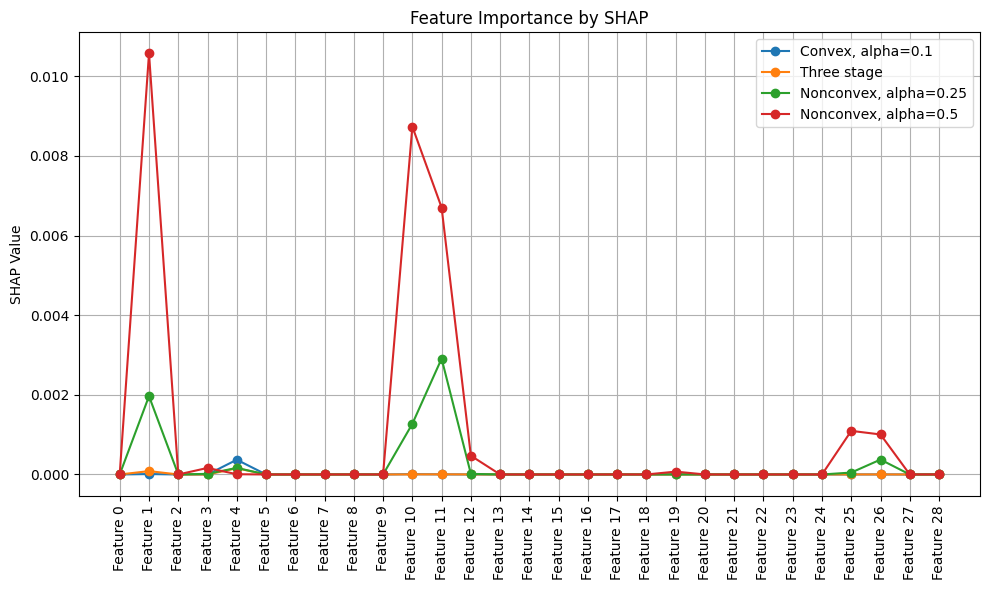

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# === Load and preprocess the SHAP file ===
shap_df = pd.read_csv("cross_validation_shap_2.csv")
shap_df.columns = shap_df.columns.str.strip()

# Convert SHAP value strings to floats
for col in shap_df.columns[1:]:
    shap_df[col] = shap_df[col].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x)

# === Step 1: Define original and custom legend names ===
selected_schedules = ["Convex Only", "Multistage_1", "Nonconvex Only", "Hybrid"]
legend_labels = {
    "Convex Only": "Convex, alpha=0.1",
    "Multistage_1": "Three stage",
    "Nonconvex Only": "Nonconvex, alpha=0.25",
    "Hybrid": "Nonconvex, alpha=0.5",
    #"Multistage_2": "Two stage",
}

# === Step 2: Plot each schedule with a custom label ===
plt.figure(figsize=(10, 6))
for schedule in selected_schedules:
    if schedule in shap_df.columns:
        plt.plot(shap_df["Schedule"], shap_df[schedule], marker='o', label=legend_labels.get(schedule, schedule))
    else:
        print(f"Warning: Schedule '{schedule}' not found.")

plt.xticks(rotation=90)
plt.ylabel("SHAP Value")
plt.title("Feature Importance by SHAP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("shap_plot_custom_legend.png")
plt.show()
